In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import plotly.express as px


## 01. Import Data ⛽



In [21]:
from google.colab import files
uploaded = files.upload()


df = pd.read_csv('my_tvl_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.set_index('date', inplace=True)
df = df[['tvl_usd']]


Saving my_tvl_data.csv to my_tvl_data.csv


# 02. EDA


In [50]:
data = df.groupby(['date'])['tvl_usd'].sum().reset_index()

fig1 = px.line(
    data,
    x='date',
    y='tvl_usd',
    title="Daily TVL USD on Ethereum Protocol Aave",
    labels={
        "date": "Date",
        "tvl_usd": "TVL (USD)"}
)

fig1.update_layout(
    xaxis_title="Date",
    yaxis_title="TVL (USD)")

fig1.show()

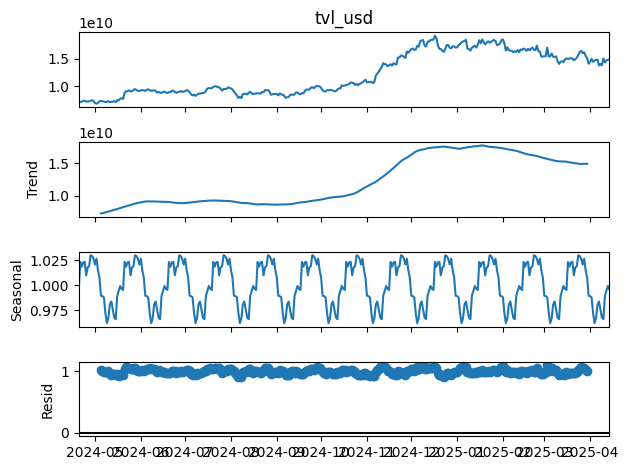

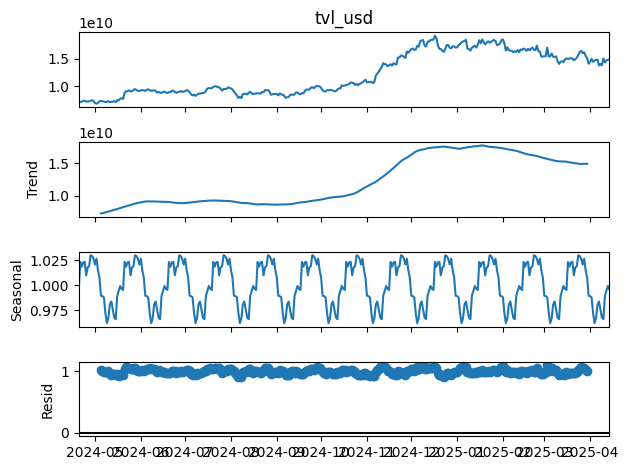

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['tvl_usd'], model= 'multiplicative' , period=30)
decomposition.plot()

In [53]:
seasonal = decomposition.seasonal
seasonal_range = seasonal.max() - seasonal.min()
seasonal_strength = seasonal_range / seasonal.mean()
print(f"Seasonal range: {seasonal_range}")
print(f"Seasonality strength (as %): {seasonal_strength * 100:.2f}%")

Seasonal range: 0.06793048184211548
Seasonality strength (as %): 6.79%


In [54]:
# diff histogram
diffs = df['tvl_usd'].diff().dropna()

fig4 = px.histogram(
    x=diffs,
    nbins=30,
    title="Histogram of TVL Daily Differences",
    labels={"x": "Daily TVL Change (USD)"},
)
fig4.update_layout(bargap=0.1)
fig4.show()

In [55]:
# check stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['tvl_usd'].diff().dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -20.390355528435542
p-value: 0.0


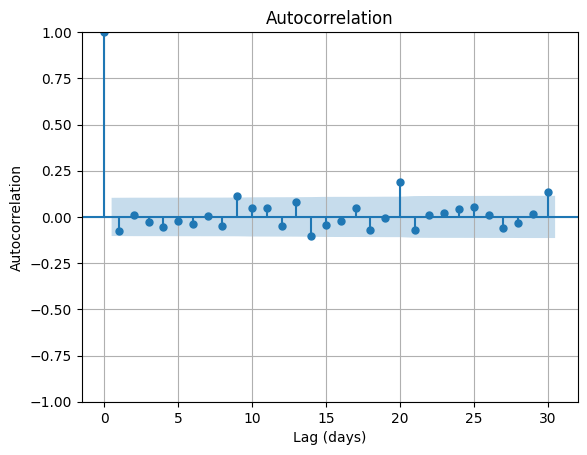

In [56]:
# check self correlation
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(diffs, lags=30)  # lags = چند روز قبل رو بررسی کنیم
#plt.title("Autocorrelation (ACF) of TVL Daily Changes")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

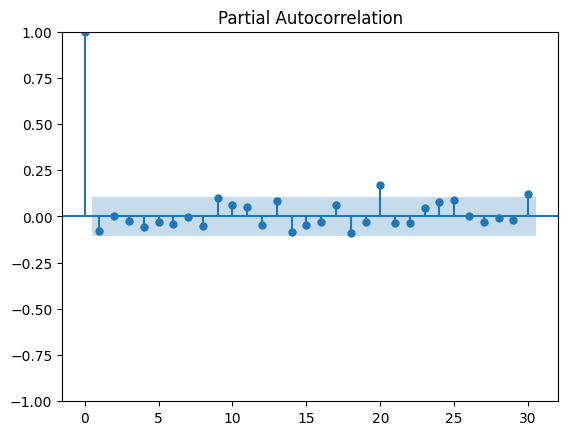

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diffs, lags=30)
plt.show()

# 03. Modeling

In [29]:
# Feature engineering
df['tvl_ma7'] = df['tvl_usd'].rolling(window=7).mean()
df['tvl_diff'] = df['tvl_usd'].diff()
df.dropna(inplace=True)


In [30]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)


In [39]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])  # فقط tvl_usd
    return np.array(X), np.array(y)

window_size = 60
X_all, y_all = create_sequences(scaled, window=window_size)


In [40]:
test_days = 60
X_train, y_train = X_all[:-test_days], y_all[:-test_days]
X_test, y_test = X_all[-test_days:], y_all[-test_days:]


In [41]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X_all.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.2170 - val_loss: 0.0622
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0688 - val_loss: 0.0743
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0676 - val_loss: 0.0728
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0720 - val_loss: 0.2253
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0669 - val_loss: 0.0791
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0621 - val_loss: 0.0547
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0568 - val_loss: 0.3124
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0712 - val_loss: 0.0527
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0536 - val_loss: 0.0887
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0559 - val_loss: 0.1094
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0496 - val_loss: 0.0455
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.

In [43]:
# ---------------------
# 7. پیش‌بینی و رسم خروجی
# ---------------------
y_pred = model.predict(X_test)

# برگرداندن مقیاس tvl_usd
tvl_scaler = MinMaxScaler()
tvl_scaler.min_, tvl_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
y_test_inv = tvl_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = tvl_scaler.inverse_transform(y_pred)

# تاریخ‌های مربوط به تست
dates_test = df.index[-test_days:]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step


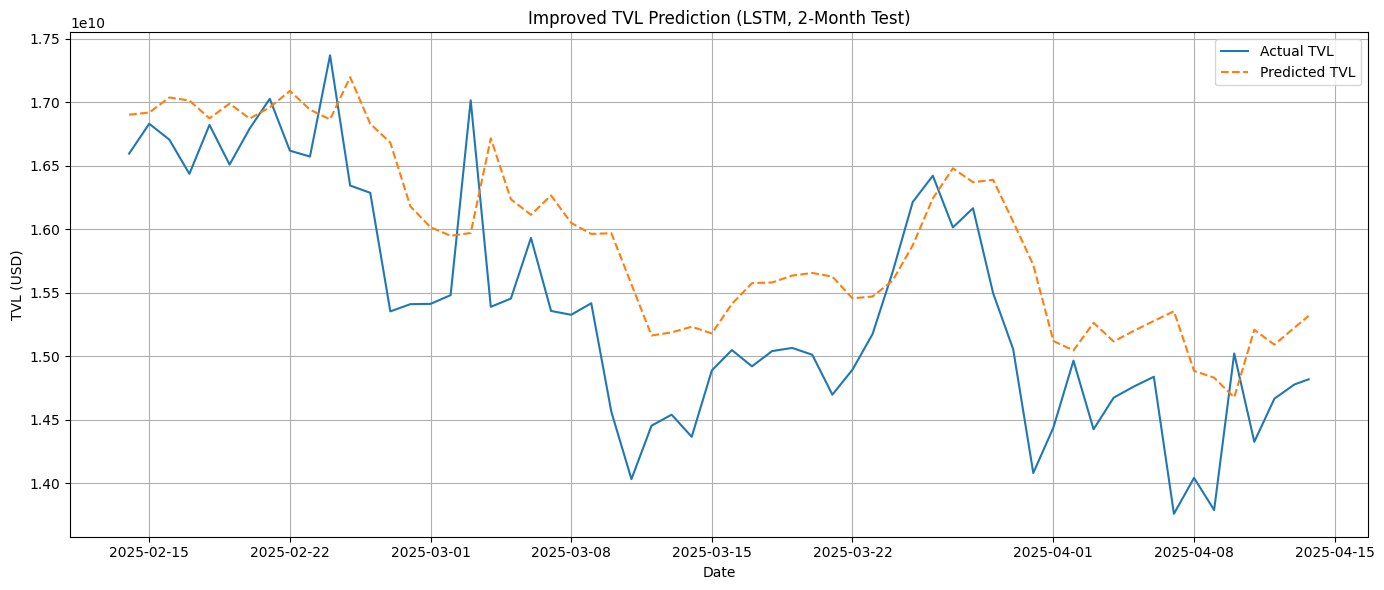

In [44]:

# نمودار
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_inv, label='Actual TVL')
plt.plot(dates_test, y_pred_inv, label='Predicted TVL', linestyle='--')
plt.title('Improved TVL Prediction (LSTM, 2-Month Test)')
plt.xlabel('Date')
plt.ylabel('TVL (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [60]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,996 (394.52 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,499 (197.27 KB)